In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [2]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/ColabNotebooks')

# # CNN Class
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF

In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
#%% Import data

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization with recommended values
                       ])

# import the data and apply the transform
dataset_train = torchvision.datasets.FashionMNIST(root='./data', download=True, train=True, transform=transform)
# dataset_test  = torchvision.datasets.FashionMNIST(root='./data', download=True, train=False,  transform=transform)

# select only 3 classes
s = ['Trouser', 'Pullover', 'Sneaker']
l = dataset_train.classes
d = np.array([i for i in range(len(l)) if l[i] in s])
t = [np.where(dataset_train.targets==d[i])[0] for i in range(len(d))]
flat_list = np.array([item for sublist in t for item in sublist])

dataset_train.data = dataset_train.data[flat_list]
dataset_train.targets = dataset_train.targets[flat_list]

print(f'dataset_train: {dataset_train.data.shape}')
# print(f'dataset_test: {dataset_test.data.shape}')

# convert to dataloaders
batchsize = 100
dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
# dataloader_test  = DataLoader(dataset_test, batch_size=256)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

dataset_train: torch.Size([18000, 28, 28])


<ipython-input-5-7acd03f01e39>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(dataset_train.data[i])


Text(0, 0.5, 'torch dataset')

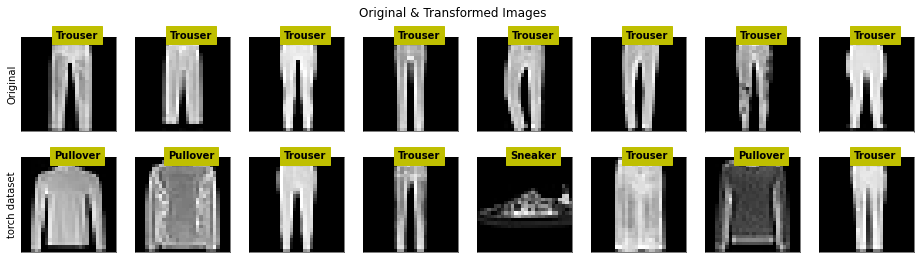

In [5]:
#%% plot some data in DataLoader

# import data from the dataloader
X, y = next(iter(dataloader_train))


# create a figure
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Original & Transformed Images')

# draw 8 first images
for i in range(8):

    # draw
    img = torch.tensor(dataset_train.data[i])
    axs[0, i].imshow(img, cmap='gray')
    
    label = dataset_train.classes[dataset_train.targets[i]]
    axs[0, i].text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    
    img = X[i].squeeze()
    axs[1, i].imshow(img, cmap='gray')

    label = dataset_train.classes[y[i]]
    axs[1, i].text(16, 0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    

    for row in range(2):
      axs[row, i].set_xticks([])
      axs[row, i].set_yticks([])

# row labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('torch dataset')

(array([44346.,   347.,   296.,   332.,   390.,   499.,   471.,   459.,
          469.,   510.,   597.,   473.,   563.,   478.,   479.,   516.,
          512.,   405.,   420.,   433.,   499.,   400.,   472.,   549.,
          484.,   558.,   530.,   655.,   605.,   650.,   906.,   772.,
          883.,   888.,   927.,   851.,   870.,   927.,   895.,   844.,
         1144.,  1376.,  1350.,  1274.,  1474.,  1201.,   892.,   642.,
          521.,  1366.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <a list of 50 Patch objects>)

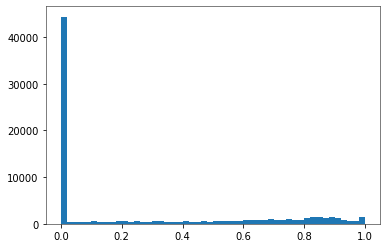

In [6]:
# check value in the img

# plot hist
x = X[:].view(-1, 1).detach().numpy()
plt.hist(x, 50)


Models Classes

In [7]:
class discriminatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(28*28, 256) # 28*28 = 784
    self.fc2 = nn.Linear(256, 256)
    self.out = nn.Linear(256, 1)

  def forward(self, x):

    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.out(x)
    x = torch.sigmoid(x)

    return x

In [8]:
class generatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(64, 256)
    self.fc2 = nn.Linear(256, 256)
    self.out = nn.Linear(256, 28*28) # 28*28 = 784

  def forward(self, x):

    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.out(x)
    x = torch.tanh(x)

    return x

Models Instance & params

In [9]:
# models instance
d_net = discriminatorNet().to(device)
g_net = generatorNet().to(device)

# loss function
loss_fun = nn.BCELoss()

# optimizer
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=.0003)

# training epochs
epochs = 50


In [61]:
# init vars to store results
d_loss = torch.zeros((epochs, len(dataloader_train))) # for discriminator
g_loss = torch.zeros((epochs, len(dataloader_train))) # for generator
d_pred_train_d = torch.zeros((epochs, len(dataloader_train))) # discriminator prediction on training discriminator
d_pred_train_g = torch.zeros((epochs, len(dataloader_train))) # discriminator prediction on training generator

Train model

In [62]:
for epochi in range(epochs):

  d_loss_batch = torch.zeros((len(dataloader_train))) # for discriminator
  g_loss_batch = torch.zeros((len(dataloader_train))) # for generator
  d_pred_train_d_batch = torch.zeros((len(dataloader_train))) # discriminator prediction on training discriminator
  d_pred_train_g_batch = torch.zeros((len(dataloader_train))) # discriminator prediction on training generator  

  batch = 0
  for real_img, _ in dataloader_train:

    if device:
        # data to GPU
        real_img = real_img.view(batchsize, -1).to(device)
        # y_batch_true_train = y_batch_true_train.to(device)

    
    # FAKE images
    fake_img = torch.randn(batchsize, 64).to(device) # torch.Size([100, 64])
    g_fake_img = g_net(fake_img) # torch.Size([100, 784]), output from generator 

    # labels for REAL and FAKE images
    real_labels = torch.ones(batchsize, 1).to(device) # all labels are 1
    fake_labels = torch.zeros(batchsize, 1).to(device) # all labels are 0


    # ----** Train discriminator **----

    # forward pass, loss: **REAL** pictures
    pred_real   = d_net(real_img) # REAL images into discriminator
    d_loss_real = loss_fun(pred_real, real_labels) 
    
    # forward pass, loss: **FAKE** pictures
    pred_fake   = d_net(g_fake_img) # FAKE images into discriminator
    d_loss_fake = loss_fun(pred_fake, fake_labels) 
    
    # loss
    d_comb_loss = d_loss_real + d_loss_fake # combine loss
    d_loss_batch[batch]  = d_comb_loss.item()
    d_pred_train_d_batch[batch] = torch.sum( (pred_real>0.5).float() ).detach() / len(pred_real)

    # backprop
    d_optimizer.zero_grad()
    d_comb_loss.backward()
    d_optimizer.step()


    # ----** Train generator **----

    # forward pass, loss: **FAKE** pictures with **REAL** labels
    fake_img = torch.randn(batchsize, 64).to(device) # torch.Size([100, 64])
    g_fake_img = g_net(fake_img) # torch.Size([100, 784]), # output from generator
    pred_fake = d_net(g_fake_img)

    # loss
    g_pred_loss = loss_fun(pred_fake, real_labels)
    g_loss_batch[batch]  = g_pred_loss.item()
    d_pred_train_g_batch[batch] = torch.sum( (pred_fake>0.5).float() ).detach() / len(pred_fake)
    
    # backprop
    g_optimizer.zero_grad()
    g_pred_loss.backward()
    g_optimizer.step()

    # batch increment
    batch += 1


  # average loss over batch
  d_loss[epochi, :] = d_loss_batch
  g_loss[epochi, :] = g_loss_batch
  d_pred_train_d[epochi, :] = d_pred_train_d_batch
  d_pred_train_g[epochi, :] = d_pred_train_g_batch
  
  # print out training epoch
  print(f'Epoch: {epochi+1}/{epochs}') if (epochi+1)%10==0 else None


Epoch: 10/50
Epoch: 20/50
Epoch: 30/50
Epoch: 40/50
Epoch: 50/50


Result

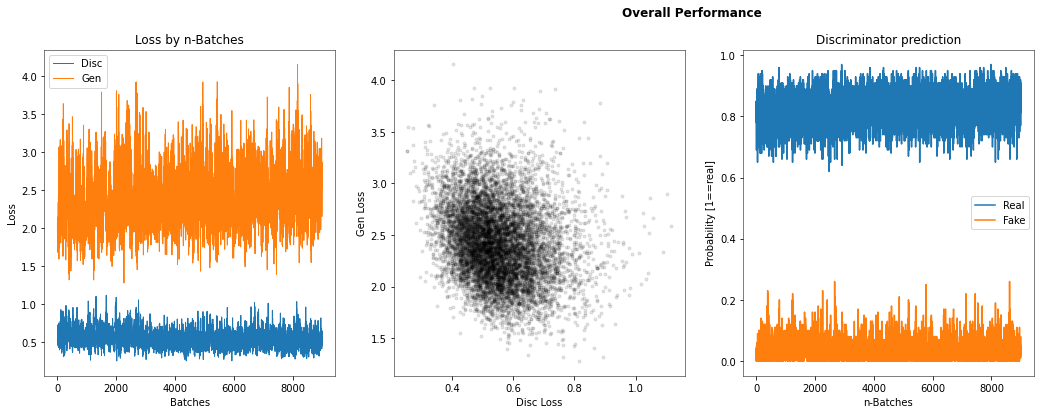

In [69]:
#%% plot model performance


# plot
fig = plt.figure(figsize=(24, 6))
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot losses
plt.subplot(1, 4, 1)
y_plot_1 = np.array(d_loss.ravel())
y_plot_2 = np.array(g_loss.ravel())
plt.plot(np.arange(0, len(y_plot_1)), y_plot_1, linewidth=1)
plt.plot(np.arange(0, len(y_plot_2)), y_plot_2, linewidth=1)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Loss by n-Batches')
plt.legend(['Disc', 'Gen'])
# plt.xlim([0, 1000])


# plot losses
plt.subplot(1, 4, 2)
y_plot_1 = np.array(d_loss.ravel())
y_plot_2 = np.array(g_loss.ravel())
plt.plot(y_plot_1, y_plot_2, 'k.', alpha=0.1)
plt.xlabel('Disc Loss')
plt.ylabel('Gen Loss')


# plot discriminator output
plt.subplot(1, 4, 3)
y_plot_1 = np.array(d_pred_train_d.ravel())
y_plot_2 = np.array(d_pred_train_g.ravel())
plt.plot(np.arange(0, len(y_plot_1)), y_plot_1)
plt.plot(np.arange(0, len(y_plot_2)), y_plot_2)
plt.title('Discriminator prediction')
plt.xlabel('n-Batches')
plt.ylabel('Probability [1==real]')
plt.legend(['Real', 'Fake'])
# plt.xlim([4000, 4100])

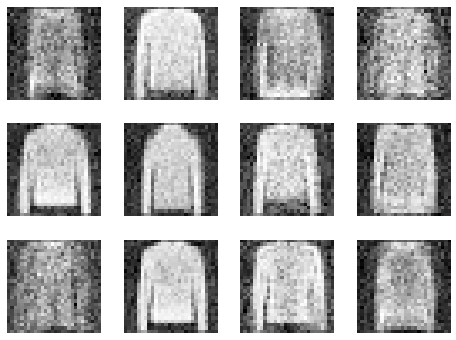

In [68]:
# generate the images from the generator network

# switch to eval mode
g_net.eval()

# create fake data
fake_data = g_net(torch.randn(12, 64).to(device)).cpu()

# plot
fig, axs = plt.subplots(3, 4, figsize=(8, 6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i, :].detach().view(28, 28), cmap='gray')
  ax.axis('off')